# Decision Trees (Random Forest)

Decision trees work kind of like a game of 20 Questions. They consider each variable in a dataset and finding its "split point." Variables with more predictive power will be used earlier in the splitting process. For example, imagine a set of data showing the freshness of various vegetables, and we want to predict whether they have spoiled or not. If one of the features is the farm of origin, and 80% of spoiled vegetables come from one particular farm, then the farm-of-origin feature will have high predictive value and be used early on in the tree-building process. From there, additional features would be considered to determine their value in predicting freshness. 

When using a simple tree, it is easy to produce a visualization (with a tree shape, of course) that shows splits and features in decreasing order of importance moving down the "tree." However, in this particular instance, I'm using random forest, which offers more powerful predictions but does not offer the same visual output that a tree does. Random forest works as an ensemble approach, combining multiple trees. The idea is that many weak learners combine their "knowledge" to create a strong learner.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import mapped version of data set here
readmit = pd.read_csv('diabetes_readmission_onehot.csv') 

In [5]:
# capture independent variables in list
features = list(readmit)
features = [e for e in features if e not in ('Unnamed: 0', 'readmit30')]

In [6]:
# split the data into a training and test set
X = readmit[features].values
y = readmit.readmit30.values
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = .2, 
                                                random_state = 31, stratify = y)

In [7]:
# build and fit model with random forest; add weights to address imbalance in dependent variables
clf_rf = RandomForestClassifier(random_state = 7, class_weight = {0: .1, 1: .9})
model_rf = clf_rf.fit(Xtrain, Ytrain)

In [8]:
# model accuracy on test data
print(model_rf.score(Xtest, Ytest))

0.906350512379


## Confusion Matrix with Precision and Recall

Another way to evaluate model performance is a confustion matrix, which puts our model's predictions into four categories:

- In the top-left quadrant is the number of observations classified as not readmitted within 30 days that were in fact not readmitted within 30 days. This is the true negative count. 
- In the top-right quadrant is the number of observations classified as readmitted within 30 days that were in fact not readmitted within 30 days. This is the false positive count. 
- In the lower left quadrant is the number of observations classified as not readmitted within 30 days that were in fact readmitted within 30 days. This is the false negative count. 
- In the lower right quadrant is the number of observations classified as readmitted within 30 days that were in fact readmitted within 30 days. This is the true positive count. 

In [23]:
# confusion matrix
actual = pd.Series(Ytest, name = 'Actual')
predicted_rf = pd.Series(clf_rf.predict(Xtest), name = 'Predicted')
rf_ct = pd.crosstab(actual, predicted_rf, margins = True)
print(rf_ct)

Predicted      0   1    All
Actual                     
0          12098  56  12154
1           1196  19   1215
All        13294  75  13369


In [24]:
# confusion matrix with percentages
TN_rf = rf_ct.iloc[0,0] / rf_ct.iloc[0,2]
TP_rf = rf_ct.iloc[1,1] / rf_ct.iloc[1,2]
Prec_rf = rf_ct.iloc[1,1] / rf_ct.iloc[2,1]
print('Percent of Non-readmissions Detected: {}'.format('%0.3f' % TN_rf))
print('Percent of Readmissions Detected (Recall): {}'.format('%0.3f' % TP_rf))
print('Accuracy Among Positive Predictions (Precision): {}'.format('%0.3f' % Prec_rf))

Accuracy for not readmitted: 0.995
Accuracy for readmitted (Recall): 0.016


Recall is a (percentage) measure of how many cases were identified correctly -- or detected -- in a given (positive or negative) class. It is also know as the true-positive or true-negative rate. In this case, for patients who were in fact readmitted within 30 days, the recall is .016 (or 1.6%) because 19 out of 1215 relevant cases were classified correctly. 

Precision is a (percentage) measure of how many predictions were correct for the positive (readmitted within 30 days, here) or negative (not readmitted) class. For the positive class, precision is .253 (or 25.3%), which comes from 19 out of 75 cases. 

These rates are not good, and the model obviously needs improvement. 

## Improvement Through Undersampling

The initial random forest did not show great results, even with class weights being adjusted. The cause may be the significant imblance in positive and negative outcomes. As we saw earlier, there are about 11 patients who were not readmitted within 30 days for every patient who was. In order to see if our model's performance is due to this imbalance, we can try the undersampling process on observations that did not show readmission within 30 days. Here, we'll use random undersampling to randomly choose fewer observations with the negative outcome in order to create a balance with positive outcomes. 

In [25]:
X = readmit[features].values #majority class to be undersampled
Y = readmit.readmit30.values 

rus = RandomUnderSampler(random_state = 34)
X_res, Y_res = rus.fit_sample(X, Y)
Counter(Y_res) 

Counter({0: 6074, 1: 6074})

In [26]:
# train, test, split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_res, Y_res, test_size = .2, 
                                                random_state = 34, stratify = Y_res)

In [27]:
# run random forest again w/ undersampled dataset
rf_rus = RandomForestClassifier(random_state = 34)
rf_model_rus = rf_rus.fit(Xtrain, Ytrain)
print(rf_model_rus.score(Xtest, Ytest))

0.707407407407


In [28]:
# confusion matrix for random forest with random undersampling
actual = pd.Series(Ytest, name = 'Actual')
predicted_rf_rus = pd.Series(rf_rus.predict(Xtest), name = 'Predicted')
ct_rf_rus = pd.crosstab(actual, predicted_rf_rus, margins = True)
print(ct_rf_rus)

Predicted     0     1   All
Actual                     
0           912   303  1215
1           408   807  1215
All        1320  1110  2430


In [29]:
# confusion matrix with percentages
TN_rf_rus = ct_rf_rus.iloc[0,0] / ct_rf_rus.iloc[0,2]
TP_rf_rus = ct_rf_rus.iloc[1,1] / ct_rf_rus.iloc[1,2]
print('Accuracy for not readmitted: {}'.format('%0.3f' % TN_rf_rus))
print('Accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_rf_rus))

Accuracy for not readmitted: 0.751
Accuracy for readmitted (Recall): 0.664


The accuracy for non-readmitted patients has dropped, which may be due to the fact that we had less data from that class this time. But the performance in that class is still well above a random guess. More importantly, the accuracy with respect to positive cases (readmitted within 30 days) is vastly improved. 

## Oversampling 

In addition to undersampling the majority class (not readmitted within 30 days), we can also try oversampling the minority class (readmitted within 30 days). Here, we'll use a common oversampling method called SMOTE (Synthetic Minority Oversampling Technique). 

In [7]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

X = readmit[features].values 
Y = readmit.readmit30.values #minority class to be oversampled

sm = SMOTE(random_state = 137)
X_resamp, Y_resamp = sm.fit_sample(X, Y)
Counter(Y_resamp) 

Counter({0: 60770, 1: 60770})

In [8]:
# train, test, split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resamp, Y_resamp, test_size = .2, 
                                                random_state = 137, stratify = Y_resamp)

In [9]:
# run random forest again w/ oversampled dataset
clf_rf_sm = RandomForestClassifier(random_state = 137)
model_rf_sm = clf_rf_sm.fit(Xtrain, Ytrain)
print(model_rf_sm.score(Xtest, Ytest))

0.950674675004


In [10]:
# confusion matrix for random forest with SMOTE oversampling
actual = pd.Series(Ytest, name = 'Actual')
predicted_rf_sm = pd.Series(clf_rf_sm.predict(Xtest), name = 'Predicted')
ct_rf_sm = pd.crosstab(actual, predicted_rf_sm, margins = True)
print(ct_rf_sm)

Predicted      0      1    All
Actual                        
0          12063     91  12154
1           1108  11046  12154
All        13171  11137  24308


In [11]:
# confusion matrix with percentages
TN_rf_sm = ct_rf_sm.iloc[0,0] / ct_rf_sm.iloc[0,2]
TP_rf_sm = ct_rf_sm.iloc[1,1] / ct_rf_sm.iloc[1,2]
Prec_rf_sm = ct_rf_sm.iloc[1,1] / ct_rf_sm.iloc[2,1] 
print('Accuracy for not readmitted: {}'.format('%0.3f' % TN_rf_sm))
print('Accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_rf_sm))
print('Correct Positive Predictions (Precision): {}'.format('%0.3f' % Prec_rf_sm))

Accuracy for not readmitted: 0.993
Accuracy for readmitted (Recall): 0.909
Correct Positive Predictions (Precision): 0.992


The accuracy for patients not readmitted is nearly perfect in the SMOTE model, and its accuracy for positive cases is excellent as well. This model seems like our best one. 

Next, we'll investigate the most important features. In the table produced below, importance indicates Gini importance, which reflects the average gain in purity by splitting on a given feature, with respect to active status. That is, Gini importance measures how well a feature minimizes the probability of misclassification. (For reference, its maximal value approaches 1, and its minimal value is 0.)

In [27]:
# gini importances of 10 most important features
importances = clf_rf_sm.feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
imp = importance_df.sort_values('importance', ascending = False)
imp.head(10)

,feature,importance
7,num_visits,0.212395
9,race_Caucasian,0.038595
55,admission_source_id_7,0.034470
12,gender_Male,0.032952
20,age_[70-80),0.028948
5,number_inpatient,0.027548
19,age_[60-70),0.026739
125,first_diag_respiratory,0.024316
2,num_medications,0.022541
70,A1Cresult_None,0.020641


HbA1c testing is an important predictor, although there are other ones with more predictive value.

In [28]:
# features with no importance
print(imp[(imp.importance == 0)])

                           feature  importance
13          gender_Unknown/Invalid         0.0
115  metformin_pioglitazone_Steady         0.0
105                    miglitol_Up         0.0
41     discharge_disposition_id_16         0.0
145        num_lab_procs_[121-132]         0.0
144        num_lab_procs_[111-120]         0.0
61          admission_source_id_14         0.0
42     discharge_disposition_id_17         0.0
87            acetohexamide_Steady         0.0
106            troglitazone_Steady         0.0
60          admission_source_id_13         0.0
59          admission_source_id_11         0.0


## Looping Processes to Correct Imbalanced Data

Now that successful corrections for the imbalanced dependent variable have been made, we can check repeat those processes a few times to ensure that we didn't "just get lucky" with the one-off uses of random undersampling and SMOTE. 

In [13]:
# capture independent variables in list
features = list(readmit) 
features = [e for e in features if e not in ('Unnamed: 0', 'readmit30')]

In [14]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

X = readmit[features].values #majority class to be undersampled
Y = readmit.readmit30.values 

In [16]:
# multiple calls of RandomUnderSampler

n_trials = 10 # number of trials

# Declare empty lists for true-positive and true-negative rates
TNR = []
TPR = [] 

# for loop such that variable "trial" varies from 0 to n_trials-1 
 # which means the loop executes n_trials times
for trial in range(n_trials):
    
    # set up random undersampling
    rus = RandomUnderSampler(random_state = 34*trial) #randomize seed
    X_res, Y_res = rus.fit_sample(X, Y)
    Counter(Y_res) 
    
    # train, test, split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_res, Y_res, test_size = .2, 
                                                random_state = 3*trial, stratify = Y_res)
    
    # run random forest 
    rf_rus = RandomForestClassifier(random_state = 34)
    rf_model_rus = rf_rus.fit(Xtrain, Ytrain)
    print(rf_model_rus.score(Xtest, Ytest))
    
    # confusion matrix for random forest with random undersampling
    actual = pd.Series(Ytest, name = 'Actual')
    predicted_rf_rus = pd.Series(rf_rus.predict(Xtest), name = 'Predicted')
    ct_rf_rus = pd.crosstab(actual, predicted_rf_rus, margins = True)
    print(ct_rf_rus)
    
    # capture given trial's true negative rate, add to array
    tnr = ct_rf_rus.iloc[0,0] / ct_rf_rus.iloc[0,2]
    TNR.append(tnr)
    
    # same process for true positive rate
    tpr = ct_rf_rus.iloc[1,1] / ct_rf_rus.iloc[1,2]
    TPR.append(tpr)
    
    # output: TNR, TPR, and trial no. 
    print('Accuracy for not readmitted: {}'.format('%0.3f' % tnr))
    print('Accuracy for readmitted (Recall): {}'.format('%0.3f' % tpr))
    print('Random Forest trial count: {}'.format(trial + 1)) 
    print()

0.726748971193
Predicted     0     1   All
Actual                     
0           944   271  1215
1           393   822  1215
All        1337  1093  2430
Accuracy for not readmitted: 0.777
Accuracy for readmitted (Recall): 0.677
Random Forest trial count: 1

0.705761316872
Predicted     0     1   All
Actual                     
0           938   277  1215
1           438   777  1215
All        1376  1054  2430
Accuracy for not readmitted: 0.772
Accuracy for readmitted (Recall): 0.640
Random Forest trial count: 2

0.712757201646
Predicted     0     1   All
Actual                     
0           909   306  1215
1           392   823  1215
All        1301  1129  2430
Accuracy for not readmitted: 0.748
Accuracy for readmitted (Recall): 0.677
Random Forest trial count: 3

0.713991769547
Predicted     0     1   All
Actual                     
0           940   275  1215
1           420   795  1215
All        1360  1070  2430
Accuracy for not readmitted: 0.774
Accuracy for readmitted (Recal

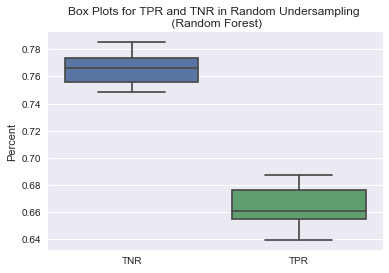

In [17]:
# plot TNR and TPR as box plots
plots = pd.DataFrame({'TPR': TPR, 'TNR': TNR})

sns.boxplot(data = plots)  
plt.title('Box Plots for TPR and TNR in Random Undersampling \n (Random Forest)')
plt.ylabel('Percent')
plt.show()

In [18]:
# multiple calls of SMOTE
from imblearn.over_sampling import SMOTE 

n_trials = 10 # number of trials

# Declare empty lists for true-positive and true-negative rates
TNR_sm = []
TPR_sm = [] 

# for loop such that variable "trial" varies from 0 to n_trials-1 
 # which means the loop executes n_trials times
for trial in range(n_trials):

    # set up SMOTE procedure
    sm = SMOTE(random_state = 13*trial)
    X_resamp, Y_resamp = sm.fit_sample(X, Y)
    Counter(Y_resamp) 
    
    # train, test, split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resamp, Y_resamp, test_size = .2, 
                                                random_state = 24*trial, stratify = Y_resamp)
    
    # run random forest again w/ oversampled dataset
    clf_rf_sm = RandomForestClassifier(random_state = 7*trial)
    model_rf_sm = clf_rf_sm.fit(Xtrain, Ytrain)
    print(model_rf_sm.score(Xtest, Ytest))
    
    # confusion matrix for random forest with SMOTE oversampling
    actual = pd.Series(Ytest, name = 'Actual')
    predicted_rf_sm = pd.Series(clf_rf_sm.predict(Xtest), name = 'Predicted')
    ct_rf_sm = pd.crosstab(actual, predicted_rf_sm, margins = True)
    print(ct_rf_sm)
    
    # capture given trial's true negative rate, add to array
    tnr_sm = ct_rf_sm.iloc[0,0] / ct_rf_sm.iloc[0,2]
    TNR_sm.append(tnr_sm)
    
    # same process for true positive rate
    tpr_sm = ct_rf_sm.iloc[1,1] / ct_rf_sm.iloc[1,2]
    TPR_sm.append(tpr_sm)
    
    # output: TNR, TPR, and trial no. 
    print('Accuracy for not readmitted: {}'.format('%0.3f' % tnr_sm))
    print('Accuracy for readmitted (Recall): {}'.format('%0.3f' % tpr_sm))
    print('Random Forest trial count: {}'.format(trial + 1)) 
    print()

0.950057594208
Predicted      0      1    All
Actual                        
0          12061     93  12154
1           1121  11033  12154
All        13182  11126  24308
Accuracy for not readmitted: 0.992
Accuracy for readmitted (Recall): 0.908
Random Forest trial count: 1

0.947630409742
Predicted      0      1    All
Actual                        
0          12026    128  12154
1           1145  11009  12154
All        13171  11137  24308
Accuracy for not readmitted: 0.989
Accuracy for readmitted (Recall): 0.906
Random Forest trial count: 2

0.953307553069
Predicted      0      1    All
Actual                        
0          12072     82  12154
1           1053  11101  12154
All        13125  11183  24308
Accuracy for not readmitted: 0.993
Accuracy for readmitted (Recall): 0.913
Random Forest trial count: 3

0.94783610334
Predicted      0      1    All
Actual                        
0          12073     81  12154
1           1187  10967  12154
All        13260  11048  24308
Accura

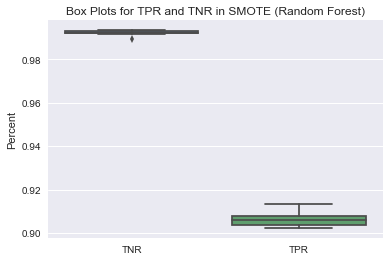

In [19]:
# plot TNR and TPR as box plots
plots_sm = pd.DataFrame({'TPR': TPR_sm, 'TNR': TNR_sm})

sns.boxplot(data = plots_sm)  
plt.title('Box Plots for TPR and TNR in SMOTE (Random Forest)')
plt.ylabel('Percent')
plt.show()